# Constant Elasticity of Substitution Planer Welfare Subsidies Optimizer Over Quantile/Individual Groups

There is some production function or other functional relationship between x and y. When x shifts, y shifts. We are interested in some function over the vector of y. We shift x to maximize some objective over the vector of y. 

$$
\max_{\left\{S_i\right\}_{i \in \left\{1,...,N\right\}}}
O \left(
    \left\{ 
    Y_{it}(X_{it}, S_i) 
    \right\}^{i \in \left\{1,...,N\right\}}
    _{t \in \left\{1,...,T\right\}}
 \right)
$$

Specifically: there is a finite amount of subsidies, there are N individuals observed between month 0 and 24. What are the optimal nutritional subsidies to provide to the N individuals given some function that relates nutritional input to outcome (height), ignoring behavior responses.

The N individuals could be N groups of individuals. There could be many more than N people that are in N groups. For example, groups determined by if someone has below or above median initial height.

## Program Structure

The program below has these ingredients. It is not written in the most generic way possible, but wrritten to work with a CES planer's optimization problem where the planer is optimizing over subsidies for sub-groups of individuals. 

1. Given a dataset, generate subsidy groups within
    - each group could have one individual or could have multiple individuals
    - dependency: [Generate Joint Quantiles from Multiple Continuous Variables as a Categorical Variable with Linear Index](https://fanwangecon.github.io/R4Econ/generate/quantile/VarCateIdxVarsQuantiles.html)
        * group linear index 
        * group label
2. Show Basic Summary Statistics for Each group
    - dependency: [All Numeric Variables Mean + SD + N by Groups](https://github.com/FanWangEcon/R4Econ/blob/master/summarize/summ/ByGroupSumm.R)
    - dependency: [By Groups, One Variable All Statistics](https://github.com/FanWangEcon/R4Econ/blob/master/summarize/summ/ByGroupSummOne.R)
3. Various Prediction Function
    - based on some estimation structure that generates overall relationship between intputs and outputs and also individual specific coefficients, some type of production function for example
    - prediction functions that generates new outputs based on subsidies for each prediction function model
    - re-write this every time. 
4. Estimation Function Wrapper
    - default parameters and key shifting parameters as inputs
    - allows for using lapply to estimate for example for multiple parameters
    - invokes optim function, and process results with function parameters
5. Inner Estimation Function
    - what optim invokes
    - estimands is first parameter
    - additional parameters as list
6. Estimation Depencies
    - for constrained to unconstrained transformation
    - for generating fractions
    - for ces objective function

## Program

### Dependencies

To achieve points 1 and 2 and 6 above.

In [181]:
library(tidyverse)
# Point 1
source('C:/Users/fan/R4Econ/summarize/summ/ByGroupSumm.R')
# Point 2
source('C:/Users/fan/R4Econ/summarize/summ/ByGroupSummOne.R')
source('C:/Users/fan/R4Econ/generate/quantile/VarCateIdxVarsQuantiles.R')
# Point 6
# get f_frac_asymp_vec()
source('C:/Users/fan/R4Econ/optimization/support/fraction.R')
# get f_planer_obj()
source('C:/Users/fan/R4Econ/optimization/planner/ces/cesplannerobj.R')

### Estimation Objective Function

In the function below:
1. x is the unconstrained transformed fraction from (optimization/support/fraction.R)
2. param.ces is the ces parameter, not that this parameter does not enter the f.subsidy.y.str function
3. f.subsidy.y.str is the name of the estimation prediction function (Step 3) in string 
4. list.subsidy.y.params.other contains a list of parameters needed for f.subsidy.y.str in addition to the 

In [182]:
# Single Parameter Optimization Functions
obj_planer <- function(x, param.ces, f.subsidy.y.str, list.subsidy.y.params.other, boo.out.y = FALSE) {

    # Input list
    # Convert from Estimation x to Actual Fraction between 0 and 1
    list.subsidy.y.params.maximand <- list(vec.subsidy.frac = f_frac_asymp_vec(x))
    list.subsidy.y.params <- append(list.subsidy.y.params.other, list.subsidy.y.params.maximand)
    
    # Call Function
    list.df.y.subsidized <- do.call(f.subsidy.y.str, list.subsidy.y.params)
    
    df.y.subsidized <- list.df.y.subsidized$dfmain
    var.y.subsidy <- list.df.y.subsidized$ysubsidy
    
    # C:\Users\fan\R4Econ\optimization\planer\ces\cesplanerobj.R
    if (boo.out.y) {        
        return(list.df.y.subsidized)
    } else {
        obj <- (-1)*f_planer_obj(vec.y=df.y.subsidized[[var.y.subsidy]], param.ces=param.ces)
        return(obj)
    }
    
}

In [183]:
# invoked obj_planer to generate full prediction dataframe with summary statistics
obj_planer_predict <- function(x, param.ces, f.subsidy.y.str, list.subsidy.y.params.other) {
    
    # Add Statistics for Outcome Variable With Subsidies
    # Generate Full Data Prediction frame
    list.df.y.subsidized <- obj_planer(x, param.ces, f.subsidy.y.str, list.subsidy.y.params.other, boo.out.y = TRUE)
    
    # FROM: summarize\summ\ByGroupSummOne.R
    # Summary statistics
    list.group.stats <- ff_summ_by_group_summ_one(list.df.y.subsidized$dfmain,
                                                  vars.group = list.subsidy.y.params.other$var.grp.idx,
                                                  var.numeric = list.df.y.subsidized$ysubsidy, 
                                                  str.stats.specify = c('mean', 'sd', 'min'), 
                                                  boo.overall.stats = TRUE)
    
    list.optim.predict <- append(list.df.y.subsidized, list.group.stats)
    
    # Return
    return(list.optim.predict)
}

In [184]:
# Subsidy Function
# var.grp.idx: name of index group variable
# subsidy.total: total subsidy
# vec.subsidy.frac: fraction of subsidy each group
# vec.subsidy.grpsize: number of people in each subsidy group.
f_subsidy_vec <- function(df, var.grp.idx, subsidy.total, vec.subsidy.frac, vec.subsidy.grpsize,
                          review=FALSE, var.i='i', var.t='t',
                          var.new.subsidy ='subsidy',
                          var.new.subsidy.grp ='subsidy_grp') {
    # var.grp.idx <- 'subsidy.grp'
    # subsidy_total <- 2
    # df.subsidy.frac <- c(0.1, 0.9)
    # vec.subsidy.grpsize <- c(1, 1)
    df.with.subsidy <- df %>% mutate(!!(var.new.subsidy.grp) := paste0(vec.subsidy.frac, collapse=','),
                                     !!(var.new.subsidy) := ((subsidy.total*
                                                              vec.subsidy.frac[df[[var.grp.idx]]])/
                                                             vec.subsidy.grpsize[df[[var.grp.idx]]]))

    if (review) {
      df.with.subsidy.review <- df.with.subsidy %>%
                                    select(!!sym(var.i), !!sym(var.t), !!sym(var.grp.idx),
                                           contains(var.new.subsidy), everything()) %>%
                                group_by(!!sym(var.grp.idx)) %>%
                                mutate_at(vars(c(var.new.subsidy)), funs(subsidy_mean_it = mean,
                                                                   subsidy_sd_it = sd,
                                                                   subsidy_n_it = n()))  %>%
                 ungroup() %>% group_by(!!sym(var.i)) %>% slice(1L) %>% group_by(!!sym(var.grp.idx)) %>%
                 mutate_at(vars(c(var.new.subsidy)), funs(subsidy_mean_i = mean,
                                                    subsidy_sd_i = sd,
                                                    subsidy_n_i = n())) %>%
                summarize_if(is.numeric, mean) %>%
                select(!!sym(var.grp.idx), contains(var.new.subsidy), everything()) %>%
                mutate_if(is.numeric, round, 3)

        print(t(df.with.subsidy.review))

    } else {

        df.with.subsidy.review <- c('')
    }

    return(list(dfmain=df.with.subsidy,
                dfreview=df.with.subsidy.review,
                varsubsidy=var.new.subsidy))
}

### Estimation Wrapper

Basically same parameters as above, except that the first parameter here are the starting values for estimation. 

1. sca.subsidy.frac.init: unconstrained fraction subsidy transformed x initial starting estimation values
2. param.ces:
3. f.subsidy.y.str: name of the estimation prediction function (Step 3) in string 
4. list.subsidy.y.params.other: contains a list of parameters needed for f.subsidy.y.str.

In [185]:
# Optimization Wrapper
# sca.subsidy.frac.init.default <- numeric((sca.subsidy.groups-1))+1
# list.subsidy.y.params.other must have: vec.subsidy.grpsize and subsidy.total
# Optimization Function
optim_wrapper <- function(sca.subsidy.frac.init, param.ces, f.subsidy.y.str, list.subsidy.y.params.other) {

    # Optimization
    res.opti <- optim(sca.subsidy.frac.init, obj_planer,
                      param.ces = param.ces,
                      f.subsidy.y.str = f.subsidy.y.str,
                      list.subsidy.y.params.other = list.subsidy.y.params.other)

    # Generate Named LIst
    sca.subsidy.lengthm1 = length(sca.subsidy.frac.init)
    list.sca.subsidy.frac.init <- setNames(sca.subsidy.frac.init,
                                           paste0('sca.subsidy.frac.init.v', 1:sca.subsidy.lengthm1))
    list.par <- setNames(res.opti$par, paste0('par.v',
                                              1:sca.subsidy.lengthm1))
    list.par.frac <- setNames(f_frac_asymp_vec(res.opti$par),
                              paste0('par.frac.v', 1:(sca.subsidy.lengthm1+1)))

    # Number of Individuals Each Subsidy Group, Normalize Relative Subidy Across Groups
    list.vec.subsidy.grpsize <- setNames(list.subsidy.y.params.other$vec.subsidy.grpsize,
                                         paste0('par.frac.grpsize.v', 1:(sca.subsidy.lengthm1+1)))
    list.vec.frac.sub.lvl <- ((f_frac_asymp_vec(res.opti$par))/(list.subsidy.y.params.other$vec.subsidy.grpsize))
    list.vec.frac.norm <- list.vec.frac.sub.lvl/sum(list.vec.frac.sub.lvl)
    list.vec.subsidy.indi.lvl <- setNames(list.vec.frac.sub.lvl*list.subsidy.y.params.other$subsidy.total,
                                         paste0('par.frac.lvl.v', 1:(sca.subsidy.lengthm1+1)))
    list.vec.subsidy.grpsize.norm <- setNames(list.vec.frac.norm,
                                         paste0('par.frac.norm.v', 1:(sca.subsidy.lengthm1+1)))
    
    # Collect Results
    list.esti.res <- list(param.ces = param.ces,
                          subsidy.total = list.subsidy.y.params.other[['subsidy.total']],
                          par.frac.sum = sum(f_frac_asymp_vec(res.opti$par)),                          
                          value = res.opti$value,
                          counts.function = (res.opti$counts)[['function']],
                          counts.gradient = (res.opti$counts)[['gradient']],
                          convergence = res.opti$convergence)

    list.esti.res <- append(list.esti.res, list.sca.subsidy.frac.init)
    list.esti.res <- append(list.esti.res, list.par)    
    list.esti.res <- append(list.esti.res, list.par.frac)
    list.esti.res <- append(list.esti.res, list.vec.subsidy.grpsize)
    list.esti.res <- append(list.esti.res, list.vec.subsidy.indi.lvl)
    list.esti.res <- append(list.esti.res, list.vec.subsidy.grpsize.norm)
    
    # Add Statistics for Outcome Variable With Subsidies
    # FROM: summarize\summ\ByGroupSummOne.R
    list.optim.predict <- obj_planer_predict(res.opti$par, param.ces, f.subsidy.y.str, list.subsidy.y.params.other)    
    list.esti.res <- append(list.esti.res, list.optim.predict$df_row_stats_all)

    # Return
    return(list.esti.res)
}

### Final Results Graph
Graphing given many CES parameters

In [186]:
# Graphically
graphf.ces.opti.subsidy <- function(df.ces.opti, sca.subsidy.groups, vec.subsidy.grpsize,
                                    str.title, str.captions, geom_text_format='%.3f') {
    df.ces.opti %>%
        gather(variable, value, -param.ces)  %>%
        ggplot(aes(x=factor(param.ces), y=value,
                   fill=variable,
                   label=sprintf(geom_text_format, value))) +
        geom_bar(stat = 'identity', position='dodge2') +
        geom_text(size=3, hjust=0.5, vjust=0, angle=0,
                  fontface = 'bold', color='black',
                  position = position_dodge(width = 1)) +
        labs(title = paste0(paste0(str.title, '\nOptimal Subsidy ',
                                   sca.subsidy.groups,' Groups, n per group=(',
                                   paste0(vec.subsidy.grpsize, collapse=',')
                              ,')\n0=Cobb-Douglas, 1=Perfect Substitutes, -Inf=Leontiff')),
               x = 'CES Parameters',
               y = 'Subsidies',
               caption = str.captions) +
        theme(axis.text.x = element_text(angle = 90, vjust=0.3, hjust = 1))
}

## Shared Parameters

Crucial Parameters, strings etc, shared across functions

In [187]:
# The name of the y-prediction variable that has subsidies added
var.new.y.subsidy <- 'y_subsidy'

## Data

### Load Data

In [188]:
# Library
library(tidyverse)

# Load Sample Data
setwd('C:/Users/fan/R4Econ/_data/')
df <- read_csv('height_weight.csv')

Parsed with column specification:
cols(
  S.country = col_character(),
  vil.id = col_double(),
  indi.id = col_double(),
  sex = col_character(),
  svymthRound = col_double(),
  momEdu = col_double(),
  wealthIdx = col_double(),
  hgt = col_double(),
  wgt = col_double(),
  hgt0 = col_double(),
  wgt0 = col_double(),
  prot = col_double(),
  cal = col_double(),
  p.A.prot = col_double(),
  p.A.nProt = col_double()
)


### Data Selection

We will have several data selection rules to generate grouped dataframe for subsidies:

1. Dataframe with two groups: below and above median initial height, each group has multiple individuals
    + implicitly, this means the planer is doing policy conditional on observable characteristics, integrating over empirical conditional distribution of unobservable.
2. Dataframe with 3 individuals: subsidy specific to each individual
    + implicitly, this would only be relevant if we know the individual type. 
3. Dataframe with 4 groups: above and below median initial height, and above below median initial weight as well.

Note for the grouped policy, we need to distinguish between individual subsidy and total group subsidy. We can adjust either, will adjust group level subsidy, then need to interpret results then as fraction of subsidy per person. Graph carefully. 

#### Data 1: df.i4xy

In [189]:
# These are the same as in: https://fanwangecon.github.io/HeightProfile/r/planer/paneloptigN.html
# Select 3 individuals, information from second year, four variables
var.qjnt.grp.idx.i4xy <- 'grp.idx.i4xy'
vars.subsidy.group <- 'i'
df.i4xy <- df %>% filter(svymthRound <= 24 & svymthRound >= 0 & 
              S.country == 'Cebu' & (indi.id == 4 | indi.id == 13  | indi.id == 15)) %>% 
              select(i = indi.id, t = svymthRound, y = hgt, x =prot) %>% 
              mutate(!!var.qjnt.grp.idx.i4xy := group_indices(., !!!syms(vars.subsidy.group))) %>%
              drop_na(i, t, y, x) 

# Obtain dataframe with quantile cut
df.i4xy.grps <- tibble(id=c(4,13,15), !!var.qjnt.grp.idx.i4xy := c(1,2,3))
sca.subsidy.groups.i4xy <- 3
vec.subsidy.grpsize.i4xy <- c(1,1,1)

# Results
print(paste0('dim(df.i4xy)=', dim(df.i4xy)[1], ',', dim(df.i4xy)[2]))
options(repr.matrix.max.rows=5, repr.matrix.max.cols=20)
df.i4xy

[1] "dim(df.i4xy)=39,5"


i,t,y,x,grp.idx.i4xy
4,0,48.4,0.5,1
4,2,53.9,1.0,1
4,4,59.8,0.5,1
...,...,...,...,...
15,22,84,8.9,3
15,24,85,20.3,3


#### Data 2: df.h0 Cebu

Generate quantile cuts. Generate two separate dataframes. 
Dataframes could bedifferent because some observations are dropped due to not having observation for the quantile by variables. 

In [190]:
# Base Data
df.cebu.t0t24 <- df %>% filter(svymthRound <= 24 & svymthRound >= 0 & 
                               S.country == 'Cebu' & 
                               indi.id <= 60 ) %>% 
            select(i = indi.id, t = svymthRound, y = hgt, x = prot, h0 = hgt0, w = wealthIdx) %>%
            drop_na(i, t, y, x, h0, w)

# Cut Quantiles
var.qjnt.grp.idx.h0 <- 'cebu.grp.idx.h0'
list.cts2quantile.h0 <- list(list(vars=c('h0'), prob=c(0, 0.5, 1.0)))
results.h0 <- df_cut_by_sliced_quantiles_joint(df.cebu.t0t24, var.qjnt.grp.idx.h0, list.cts2quantile.h0,
                                               vars.group_by = c('i'), vars.arrange = c('i', 't'),
                                               drop.any.quantile.na = TRUE, toprint = FALSE)
# Obtain dataframe with quantile cut
df.h0 <- results.h0$df.with.cut.quant
df.h0.grps <- results.h0$df.group.slice1.cnt.mean
sca.subsidy.groups.h0 <- dim(df.h0.grps)[1]
vec.subsidy.grpsize.h0 <- df.h0.grps$n

# Show Stats
print(paste0('dim(df.h0)=', dim(df.h0)[1], ',', dim(df.h0)[2]))
df.h0.grps 
print(paste0('vec.subsidy.grpsize.h0=', paste0(vec.subsidy.grpsize.h0, collapse=',')))
print(paste0('sca.subsidy.groups.h0=', sca.subsidy.groups.h0))

[1] "dim(df.h0)=749,8"


h0_Qs0e1n2,cebu.grp.idx.h0,mean,n
"[44.2,49.4]; (1) of Qs0e1n2",1,47.99677,31
"(49.4,54]; (2) of Qs0e1n2",2,50.99655,29


[1] "vec.subsidy.grpsize.h0=31,29"
[1] "sca.subsidy.groups.h0=2"


#### Data 3: df.h0wlt Guatemala

Two Variables Quantile Cut Guatemala.

In [191]:
# Base Data Women Guatemala
df.guat.t0t24 <- df %>% filter(svymthRound <= 24 & svymthRound >= 0 & 
                               S.country == 'Guatemala') %>% 
            select(i = indi.id, t = svymthRound, y = hgt, x = prot, h0 = hgt0, w = wealthIdx) %>%
            drop_na(i, t, y, x, h0, w)

# Cut Quantiles
var.qjnt.grp.idx.h0wlt <- 'guat.grp.idx.h0wlt'
list.cts2quantile.h0wlt <- list(list(vars=c('h0'), prob=c(0, 0.5, 1.0)), 
                          list(vars=c('w'), prob=c(0, 0.5, 1.0)))
results.h0wlt <- df_cut_by_sliced_quantiles_joint(df.guat.t0t24, var.qjnt.grp.idx.h0wlt, list.cts2quantile.h0wlt,
                                                  vars.group_by = c('i'), vars.arrange = c('i', 't'),
                                                  drop.any.quantile.na = TRUE, toprint = FALSE)
# Obtain dataframe with quantile cut
df.h0wlt <- results.h0wlt$df.with.cut.quant
df.h0wlt.grps <- results.h0wlt$df.group.slice1.cnt.mean
sca.subsidy.groups.h0wlt <- dim(df.h0wlt.grps)[1]
vec.subsidy.grpsize.h0wlt <- df.h0wlt.grps$h0_n

# Show Stats
print(paste0('dim(df.h0wlt)=', dim(df.h0wlt)[1], ',', dim(df.h0wlt)[2]))
df.h0wlt.grps
print(paste0('vec.subsidy.grpsize.h0wlt=', paste0(vec.subsidy.grpsize.h0wlt, collapse=',')))
print(paste0('sca.subsidy.groups.h0wlt=', sca.subsidy.groups.h0wlt))

Joining, by = c("i", "t", "y", "x", "h0", "w")


[1] "dim(df.h0wlt)=1808,9"


h0_Qs0e1n2,w_Qs0e1n2,guat.grp.idx.h0wlt,h0_mean,w_mean,h0_n,w_n
"[40.6,49.9]; (1) of Qs0e1n2","[1,2.2]; (1) of Qs0e1n2",1,47.64340,1.725472,106,106
"[40.6,49.9]; (1) of Qs0e1n2","(2.2,5.7]; (2) of Qs0e1n2",2,48.33924,3.153165,79,79
"(49.9,56.7]; (2) of Qs0e1n2","[1,2.2]; (1) of Qs0e1n2",3,51.45867,1.654667,75,75
"(49.9,56.7]; (2) of Qs0e1n2","(2.2,5.7]; (2) of Qs0e1n2",4,51.72400,3.090000,100,100


[1] "vec.subsidy.grpsize.h0wlt=106,79,75,100"
[1] "sca.subsidy.groups.h0wlt=4"


## Estimation and Prediction Functions

Run Estimations Separately for different Data group, and generate different prediction functions based on them. 

Only three fixed effects for df.i4xy, about 60 for df.h0, and then about 360 for df.h0wlt. 

First run a timer.

In [192]:
# Regressions
f_res_linfe <- function(df) lm(log(y) ~ log(x) + factor(i) - 1 , data=df)

In [193]:
# Timing
system.time({f_res_linfe(df.i4xy)})
system.time({f_res_linfe(df.h0)})
system.time({f_res_linfe(df.h0wlt)})

   user  system elapsed 
      0       0       0 

   user  system elapsed 
      0       0       0 

   user  system elapsed 
   0.14    0.00    0.16 

In [194]:
# StoreEstimation Results
res.linfe.i4xy <- lm(log(y) ~ log(x) + factor(i) - 1 , data=df.i4xy)
res.linfe.h0 <- lm(log(y) ~ log(x) + factor(i) - 1 , data=df.h0)
res.linfe.h0wlt <- lm(log(y) ~ log(x) + factor(i) - 1 , data=df.h0wlt)

In [195]:
# Summaries
# str(res.linfe.h0)
# summary(res.linfe.h0)
# summary(res.linfe.h0wlt)
# summary(res.linfe.i4xy)

In [196]:
# Function 2
f_subsidy_y_cd <- function(df, res.linfe,
                           var.grp.idx, subsidy.total,
                           vec.subsidy.frac, vec.subsidy.grpsize,
                           var.new.y.subsidy,
                           review=FALSE) {
    
    # Invoke Function 1
    list.df.subsidy <- f_subsidy_vec(df, var.grp.idx, subsidy.total,
                                         vec.subsidy.frac, vec.subsidy.grpsize, review)
    
    df.subsidy <- list.df.subsidy$dfmain
    
    # Y with subsidy for linear regresion model
    df.hgt.adj <- df.subsidy %>% mutate(!!(var.new.y.subsidy) := 
                                        exp(predict(res.linfe, 
                                                    (df.subsidy %>% 
                                                     mutate(x = x + subsidy)))))
    
    return(list(dfmain=df.hgt.adj,
                ysubsidy=var.new.y.subsidy))
}

## Planer Optimization Parameters Set Up

### For 3 Individuals

In [197]:
subsidy.total.default.person <- 30

In [198]:
# These are the same as in: https://fanwangecon.github.io/HeightProfile/r/planer/paneloptigN.html
# Should produce the same results
# Default Parameters for Estimation Set up
f.subsidy.y.str.i4xy <- 'f_subsidy_y_cd'
# t.filter.default.i4xy <- 24
subsidy.total.default.i4xy <- subsidy.total.default.person*sum(vec.subsidy.grpsize.i4xy)
# lists of Inputs
df.default.i4xy <- df.i4xy 
# NOTE DO NOT INCLUDE in other.default: vec.subsidy.frac, that is set by optim 
list.subsidy.y.params.other.default.i4xy <- list(df = df.default.i4xy, 
                                                 res.linfe = res.linfe.i4xy,
                                                 var.grp.idx = var.qjnt.grp.idx.i4xy,
                                                 subsidy.total = subsidy.total.default.i4xy,
                                                 vec.subsidy.grpsize = vec.subsidy.grpsize.i4xy,
                                                 var.new.y.subsidy = var.new.y.subsidy)
list.subsidy.y.params.maximand.default.i4xy <- list(review = TRUE,
                                                    vec.subsidy.frac = round(f_subsidy_frac(sca.subsidy.groups.i4xy, 'rand', seed=13), 3))
# Overall
list.subsidy.y.params.i4xy <- append(list.subsidy.y.params.other.default.i4xy,
                                     list.subsidy.y.params.maximand.default.i4xy)

### For h0 Cebu 60 people

In [199]:
# Default Parameters for Estimation Set up
f.subsidy.y.str.h0 <- 'f_subsidy_y_cd'
t.filter.default.h0 <- 24
subsidy.total.default.h0 <- subsidy.total.default.person*sum(vec.subsidy.grpsize.h0)

df.default.h0 <- df.h0 %>% filter(t == t.filter.default.h0)

# lists of Inputs
# NOTE DO NOT INCLUDE in other.default: vec.subsidy.frac, that is set by optim 
list.subsidy.y.params.other.default.h0 <- list(df = df.default.h0, 
                                               res.linfe = res.linfe.h0,
                                               var.grp.idx = var.qjnt.grp.idx.h0,
                                               subsidy.total = subsidy.total.default.h0,
                                               vec.subsidy.grpsize = vec.subsidy.grpsize.h0, 
                                               var.new.y.subsidy = var.new.y.subsidy)
list.subsidy.y.params.maximand.default.h0 <- list(review = TRUE, vec.subsidy.frac =
                                               round(f_subsidy_frac(sca.subsidy.groups.h0, 'unif', seed=13), 3))

# Overall
list.subsidy.y.params.h0 <- append(list.subsidy.y.params.other.default.h0,
                                   list.subsidy.y.params.maximand.default.h0)

### For h0wlt Guatemala

In [200]:
# Default Parameters for Estimation Set up
f.subsidy.y.str.h0wlt <- 'f_subsidy_y_cd'
t.filter.default.h0wlt <- 24
# 3 people 100, 300 people now
subsidy.total.default.h0wlt <- subsidy.total.default.person*sum(vec.subsidy.grpsize.h0wlt)

df.default.h0wlt <- df.h0wlt %>% filter(t == t.filter.default.h0wlt)
# NOTE DO NOT INCLUDE in other.default: vec.subsidy.frac, that is set by optim 
list.subsidy.y.params.other.default.h0wlt <- list(df = df.default.h0wlt, 
                                                  res.linfe = res.linfe.h0wlt,
                                                  var.grp.idx = var.qjnt.grp.idx.h0wlt,
                                                  subsidy.total = subsidy.total.default.h0wlt, 
                                                  vec.subsidy.grpsize = vec.subsidy.grpsize.h0wlt, 
                                                  var.new.y.subsidy = var.new.y.subsidy)
list.subsidy.y.params.maximand.default.h0wlt <- list(review = TRUE, vec.subsidy.frac = 
                                                     round(f_subsidy_frac(sca.subsidy.groups.h0wlt, 'unif', seed=13), 3))

# Overall
list.subsidy.y.params.h0wlt <- append(list.subsidy.y.params.other.default.h0wlt,
                                      list.subsidy.y.params.maximand.default.h0wlt)

### Testing Prediction Function

In [201]:
# Overall Parameter vector
options(repr.matrix.max.rows=5, repr.matrix.max.cols=20)
do.call(f.subsidy.y.str.i4xy, list.subsidy.y.params.i4xy)

                 [,1]  [,2]  [,3]
grp.idx.i4xy     1.00  2.00  3.00
subsidy         47.52 16.47 26.01
subsidy_mean_it 47.52 16.47 26.01
subsidy_sd_it    0.00  0.00  0.00
subsidy_n_it    13.00 13.00 13.00
subsidy_mean_i  47.52 16.47 26.01
subsidy_sd_i      NaN   NaN   NaN
subsidy_n_i      1.00  1.00  1.00
i                4.00 13.00 15.00
t                0.00  0.00  0.00
y               48.40 49.30 52.50
x                0.50  0.50  0.50


i,t,y,x,grp.idx.i4xy,subsidy_grp,subsidy,y_subsidy
4,0,48.4,0.5,1,"0.528,0.183,0.289",47.52,94.32824
4,2,53.9,1.0,1,"0.528,0.183,0.289",47.52,94.43198
4,4,59.8,0.5,1,"0.528,0.183,0.289",47.52,94.32824
...,...,...,...,...,...,...,...
15,22,84,8.9,3,"0.528,0.183,0.289",26.01,90.00413
15,24,85,20.3,3,"0.528,0.183,0.289",26.01,92.74389


In [202]:
options(repr.matrix.max.rows=5, repr.matrix.max.cols=20)
do.call(f.subsidy.y.str.h0, list.subsidy.y.params.h0)

                  [,1]   [,2]
cebu.grp.idx.h0  1.000  2.000
subsidy         29.032 31.034
subsidy_mean_it 29.032 31.034
subsidy_sd_it    0.000  0.000
subsidy_n_it    30.000 27.000
subsidy_mean_i  29.032 31.034
subsidy_sd_i     0.000  0.000
subsidy_n_i     30.000 27.000
i               34.333 26.222
t               24.000 24.000
y               78.557 79.500
x               19.060 18.019
h0              48.123 51.067
w                9.297  8.363


i,t,y,x,h0,w,h0_Qs0e1n2,cebu.grp.idx.h0,subsidy_grp,subsidy,y_subsidy
2,24,79.2,14.1,49.7,7.3,"(49.4,54]; (2) of Qs0e1n2",2,"0.5,0.5",31.03448,85.70456
3,24,76.7,20.6,51.7,10.3,"(49.4,54]; (2) of Qs0e1n2",2,"0.5,0.5",31.03448,78.28437
4,24,78.1,10.3,50.2,13.3,"(49.4,54]; (2) of Qs0e1n2",2,"0.5,0.5",31.03448,87.84156
...,...,...,...,...,...,...,...,...,...,...
58,24,80.3,8.7,46.7,10.3,"[44.2,49.4]; (1) of Qs0e1n2",1,"0.5,0.5",29.03226,77.16255
60,24,79.2,6.9,49.4,7.3,"[44.2,49.4]; (1) of Qs0e1n2",1,"0.5,0.5",29.03226,81.82674


In [203]:
options(repr.matrix.max.rows=5, repr.matrix.max.cols=20)
do.call(f.subsidy.y.str.h0wlt, list.subsidy.y.params.h0wlt)

                       [,1]     [,2]     [,3]     [,4]
guat.grp.idx.h0wlt    1.000    2.000    3.000    4.000
subsidy              25.472   34.177   36.000   27.000
subsidy_mean_it      25.472   34.177   36.000   27.000
subsidy_sd_it         0.000    0.000    0.000    0.000
subsidy_n_it         74.000   53.000   48.000   63.000
subsidy_mean_i       25.472   34.177   36.000   27.000
subsidy_sd_i          0.000    0.000    0.000    0.000
subsidy_n_i          74.000   53.000   48.000   63.000
i                  1743.432 1679.453 1708.708 1673.746
t                    24.000   24.000   24.000   24.000
y                    75.804   76.625   78.175   78.771
x                    26.550   23.989   27.506   28.148
h0                   47.673   48.275   51.327   51.486
w                     1.711    3.187    1.652    3.119


i,t,y,x,h0,w,h0_Qs0e1n2,w_Qs0e1n2,guat.grp.idx.h0wlt,subsidy_grp,subsidy,y_subsidy
1352,24,75.8,46.3,47.4,3.3,"[40.6,49.9]; (1) of Qs0e1n2","(2.2,5.7]; (2) of Qs0e1n2",2,"0.25,0.25,0.25,0.25",34.17722,77.36775
1354,24,75.3,15.4,51.2,1.7,"(49.9,56.7]; (2) of Qs0e1n2","[1,2.2]; (1) of Qs0e1n2",3,"0.25,0.25,0.25,0.25",36.00000,78.00260
1356,24,77.1,30.5,51.9,3.4,"(49.9,56.7]; (2) of Qs0e1n2","(2.2,5.7]; (2) of Qs0e1n2",4,"0.25,0.25,0.25,0.25",27.00000,77.43604
...,...,...,...,...,...,...,...,...,...,...,...
2018,24,77.2,31.7,48.8,2.1,"[40.6,49.9]; (1) of Qs0e1n2","[1,2.2]; (1) of Qs0e1n2",1,"0.25,0.25,0.25,0.25",25.4717,76.4070
2019,24,76.8,57.8,49.7,2.2,"[40.6,49.9]; (1) of Qs0e1n2","[1,2.2]; (1) of Qs0e1n2",1,"0.25,0.25,0.25,0.25",25.4717,73.5095


## Testing Planer Optimization At Single CES Parameter Value

Single CES Planer Optimization problem. 

In [204]:
options(warn=-1) # Suppress Warning Messages
# optim_wrapper() from C:\Users\fan\R4Econ\optimization\planer\ces\cesoptimizer.R
param.ces <- -100

In [205]:
# test i4xy
res.opti.test.i4xy <- optim_wrapper(sca.subsidy.frac.init = (numeric((sca.subsidy.groups.i4xy-1))+1), 
                                    param.ces = param.ces, f.subsidy.y.str = f.subsidy.y.str.i4xy,
                                    list.subsidy.y.params.other = list.subsidy.y.params.other.default.i4xy)

In [206]:
# test h0
res.opti.test.h0 <- optim_wrapper(sca.subsidy.frac.init = (numeric((sca.subsidy.groups.h0-1))+1), 
                                  param.ces = param.ces, f.subsidy.y.str = f.subsidy.y.str.h0,
                                  list.subsidy.y.params.other = list.subsidy.y.params.other.default.h0)

In [207]:
# test h0wlt
res.opti.test.h0wlt <- optim_wrapper(sca.subsidy.frac.init = (numeric((sca.subsidy.groups.h0wlt-1))+1), 
                                     param.ces = param.ces, f.subsidy.y.str = f.subsidy.y.str.h0wlt,
                                     list.subsidy.y.params.other = list.subsidy.y.params.other.default.h0wlt)

In [208]:
# Display Test Results
options(repr.matrix.max.rows=60, repr.matrix.max.cols=20)
df.test.results <- list(df_i4xy=res.opti.test.i4xy,
                        df_h0_cebu=res.opti.test.h0, 
                        df_h0wlt_guat=res.opti.test.h0wlt)
# Show Results From Tests
# list.names = list of list first level names
# list.of.list.names = list of list second level names
as.data.frame(df.test.results) %>%
    gather(variable, value) %>%
    separate(variable, c('list.names', 'list.of.list.names'),
             sep = "\\.", extra = "merge") %>%
    spread(list.names, value) %>%
    column_to_rownames(var='list.of.list.names')

,df_h0_cebu,df_h0wlt_guat,df_i4xy
convergence,0.0000000,0.000000e+00,0.00000000
counts.function,18.0000000,1.140000e+02,69.00000000
counts.gradient,NA,NA,NA
par.frac.grpsize.v1,31.0000000,1.060000e+02,1.00000000
par.frac.grpsize.v2,29.0000000,7.900000e+01,1.00000000
par.frac.grpsize.v3,NA,7.500000e+01,1.00000000
par.frac.grpsize.v4,NA,1.000000e+02,NA
par.frac.lvl.v1,44.1502877,4.774593e+01,28.08922207
par.frac.lvl.v2,14.8738304,2.801595e+01,31.54196108
par.frac.lvl.v3,NA,3.669750e+01,30.36881685


## Optimization Many CES Parameters

Now We Loop over different CES Parameters and Analyze Optimal Policies.

In [209]:
# Initialize
# C:\Users\fan\R4Econ\optimization\planer\ces\cesplanerobj.R
vec.param.ces <- f_ces_params_vec(3, 6)
options(warn=-1) # Suppress Warning Messages

param.ces,-160.0000000,-58.0000000,-21.0000000,-8.0000000,-3.0000000,-1.0000000,-0.0100000,0.9900000
par.frac.norm.v1,0.3028461,0.3143323,0.3201091,0.3278539,0.3353681,0.3405066,0.3436284,0.3480063
par.frac.norm.v2,0.3538148,0.3506671,0.3495459,0.3454204,0.3410788,0.3380481,0.3361046,0.3333661
par.frac.norm.v3,0.3433392,0.3350006,0.3303449,0.3267257,0.3235530,0.3214454,0.3202670,0.3186275


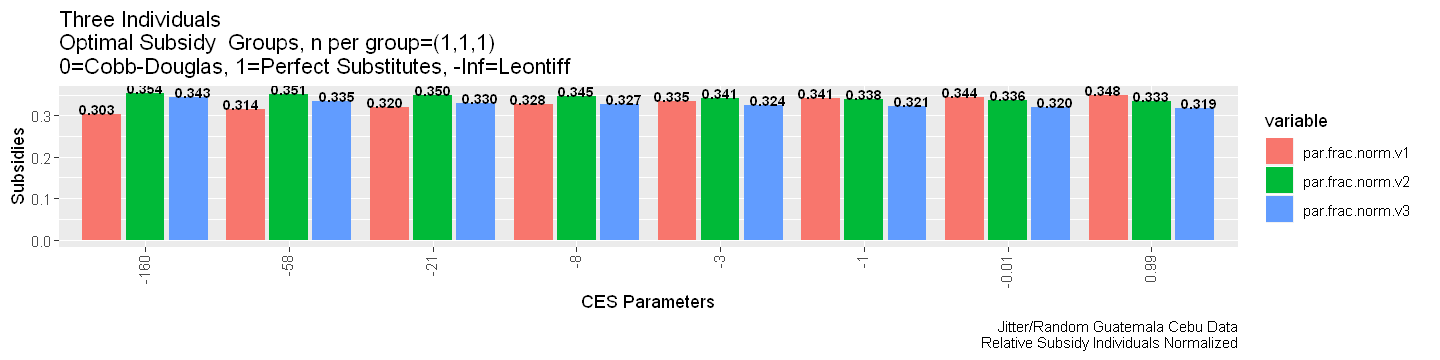

In [210]:
# Call i4xy
df.ces.opti.i4xy <- bind_rows(lapply(vec.param.ces, optim_wrapper, 
                                list.subsidy.y.params.other = list.subsidy.y.params.other.default.i4xy,
                                sca.subsidy.frac.init = (numeric((sca.subsidy.groups.i4xy-1))+1), 
                                f.subsidy.y.str = 'f_subsidy_y_cd')) %>% 
                    select(param.ces, matches('par.frac.norm.v'))
t(df.ces.opti.i4xy)
# Graph
options(repr.plot.width = 12, repr.plot.height = 3)
str.title <- 'Three Individuals'
str.captions <- 'Jitter/Random Guatemala Cebu Data\nRelative Subsidy Individuals Normalized'
graphf.ces.opti.subsidy(df.ces.opti=df.ces.opti.i4xy,
                        sca.subsidy.groups = list.subsidy.y.params.other.default.i4xy$sca.subsidy.groups,
                        vec.subsidy.grpsize =  list.subsidy.y.params.other.default.i4xy$vec.subsidy.grpsize, 
                        str.title=str.title, str.captions=str.captions)

param.ces,-160.000000,-58.0000000,-21.0000000,-8.0000000,-3.0000000,-1.0000000,-0.0100000,9.900000e-01
subsidy.total,1800.000000,1800.0000000,1800.0000000,1800.0000000,1800.0000000,1800.0000000,1800.0000000,1.800000e+03
par.frac.sum,1.000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.000000e+00
value,-72.865213,-76.4888863,-79.2232660,-80.8119194,-81.4997430,-81.7852346,-81.9293075,-8.207723e+01
counts.function,40.000000,14.0000000,22.0000000,22.0000000,20.0000000,20.0000000,24.0000000,2.000000e+01
counts.gradient,NA,NA,NA,NA,NA,NA,NA,NA
convergence,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000e+00
sca.subsidy.frac.init.v1,1.000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.000000e+00
par.v1,1.341290,1.0125000,0.6890625,0.4234375,0.2406250,0.1312500,0.0718750,-8.881784e-16
par.frac.v1,0.792702,0.7335091,0.6657583,0.6043055,0.5598677,0.5327655,0.5179610,5.000000e-01
par.frac.v2,0.207298,0.2664909,0.3342417,0.3956945,0.4401323,0.4672345,0.4820390,5.000000e-01


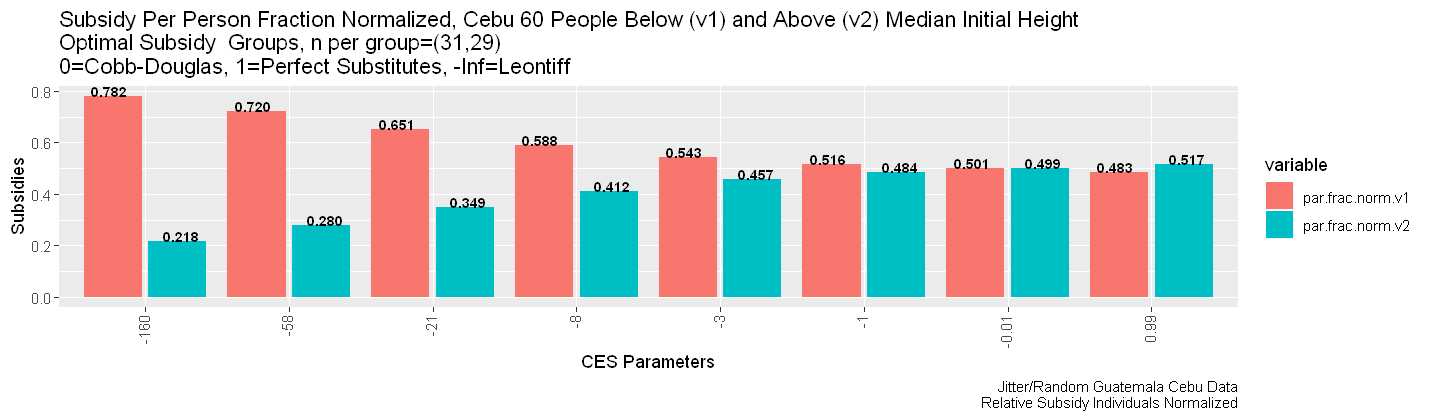

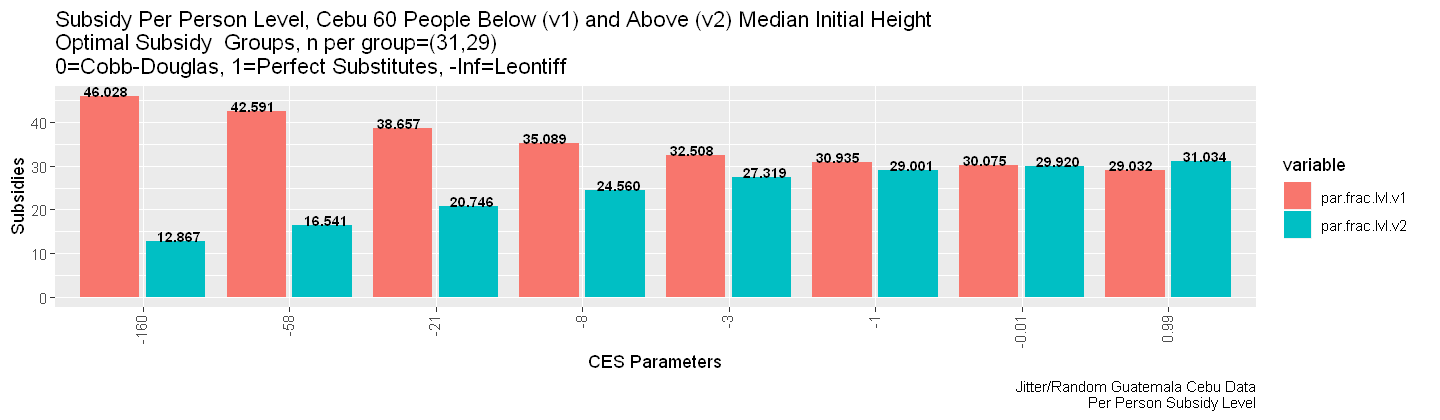

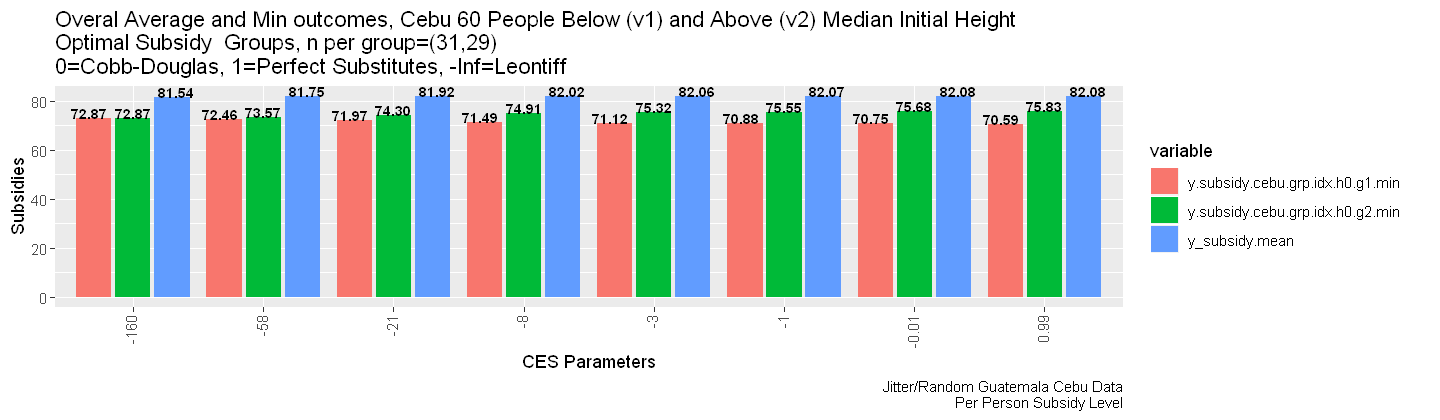

In [211]:
# test h0
df.ces.opti.h0 <- bind_rows(lapply(vec.param.ces, optim_wrapper, 
                                list.subsidy.y.params.other = list.subsidy.y.params.other.default.h0,
                                sca.subsidy.frac.init = (numeric((sca.subsidy.groups.h0-1))+1), 
                                f.subsidy.y.str = 'f_subsidy_y_cd'))
t(df.ces.opti.h0)
# Graph
options(repr.plot.width = 12, repr.plot.height = 3.5)
sca.subsidy.groups = list.subsidy.y.params.other.default.h0$sca.subsidy.groups
vec.subsidy.grpsize =  list.subsidy.y.params.other.default.h0$vec.subsidy.grpsize
# Two Graphs
# G1 
str.title <- 'Subsidy Per Person Fraction Normalized, Cebu 60 People Below (v1) and Above (v2) Median Initial Height'
str.captions <- 'Jitter/Random Guatemala Cebu Data\nRelative Subsidy Individuals Normalized'
graphf.ces.opti.subsidy(df.ces.opti=df.ces.opti.h0 %>% select(param.ces, matches('par.frac.norm.v')),
                        sca.subsidy.groups = sca.subsidy.groups, vec.subsidy.grpsize = vec.subsidy.grpsize, 
                        str.title=str.title, str.captions=str.captions)
str.title <- 'Subsidy Per Person Level, Cebu 60 People Below (v1) and Above (v2) Median Initial Height'
str.captions <- 'Jitter/Random Guatemala Cebu Data\nPer Person Subsidy Level'
graphf.ces.opti.subsidy(df.ces.opti=df.ces.opti.h0 %>% select(param.ces, matches('par.frac.lvl.v')),
                        sca.subsidy.groups = sca.subsidy.groups, vec.subsidy.grpsize = vec.subsidy.grpsize, 
                        str.title=str.title, str.captions=str.captions)
str.title <- 'Overal Average and Min outcomes, Cebu 60 People Below (v1) and Above (v2) Median Initial Height'
str.captions <- 'Jitter/Random Guatemala Cebu Data\nPer Person Subsidy Level'
graphf.ces.opti.subsidy(df.ces.opti=df.ces.opti.h0 %>% select(param.ces,
                                                              y.subsidy.cebu.grp.idx.h0.g1.min,
                                                              y.subsidy.cebu.grp.idx.h0.g2.min, 
                                                              y_subsidy.mean),
                        sca.subsidy.groups = sca.subsidy.groups, vec.subsidy.grpsize = vec.subsidy.grpsize, 
                        str.title=str.title, str.captions=str.captions, geom_text_format='%.2f')

param.ces,-1.600000e+02,-5.800000e+01,-2.100000e+01,-8.0000000,-3.0000000,-1.0000000,-0.0100000,0.9900000
subsidy.total,1.080000e+04,1.080000e+04,1.080000e+04,10800.0000000,10800.0000000,10800.0000000,10800.0000000,10800.0000000
par.frac.sum,1.000000e+00,1.000000e+00,1.000000e+00,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
value,-6.989605e+01,-7.412007e+01,-7.619396e+01,-76.9993587,-77.3132916,-77.4406441,-77.5042449,-77.5689787
counts.function,1.780000e+02,1.480000e+02,1.240000e+02,132.0000000,128.0000000,164.0000000,116.0000000,108.0000000
counts.gradient,NA,NA,NA,NA,NA,NA,NA,NA
convergence,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
sca.subsidy.frac.init.v1,1.000000e+00,1.000000e+00,1.000000e+00,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
sca.subsidy.frac.init.v2,1.000000e+00,1.000000e+00,1.000000e+00,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
sca.subsidy.frac.init.v3,1.000000e+00,1.000000e+00,1.000000e+00,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
par.v1,1.240356e-01,-2.405590e-01,-3.740779e-01,-0.5211500,-0.6350898,-0.7000372,-0.7407843,-0.7771841


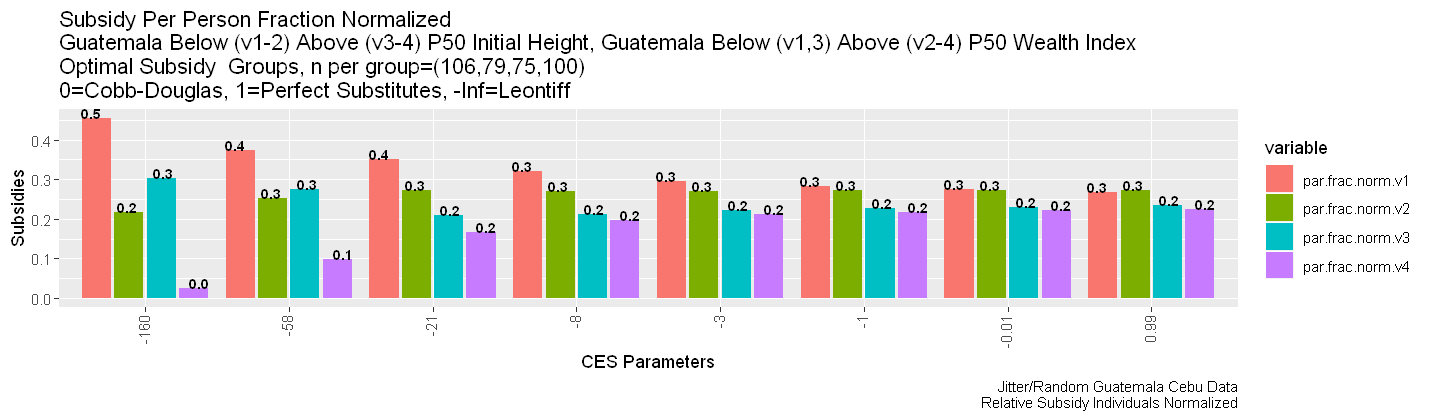

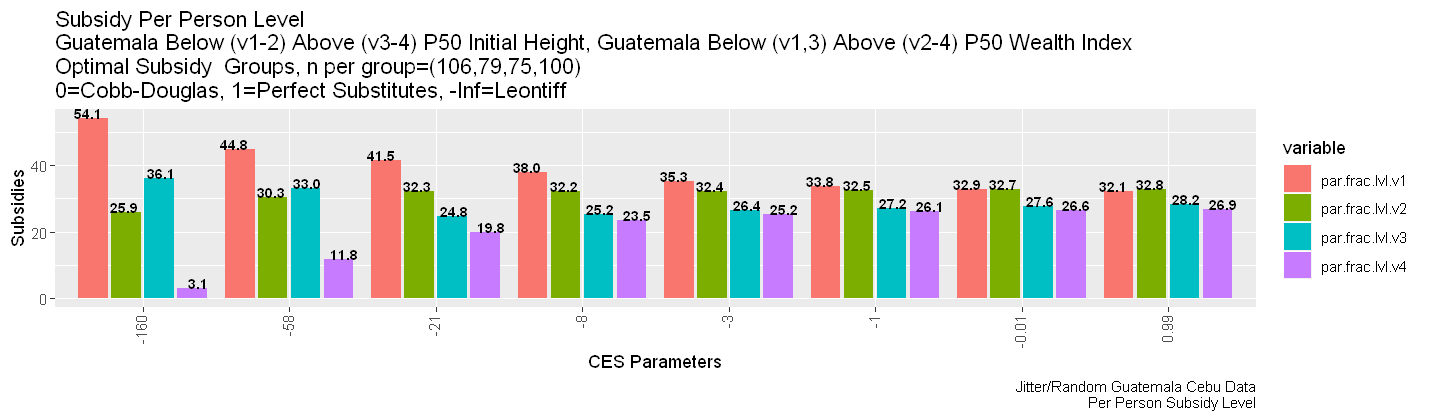

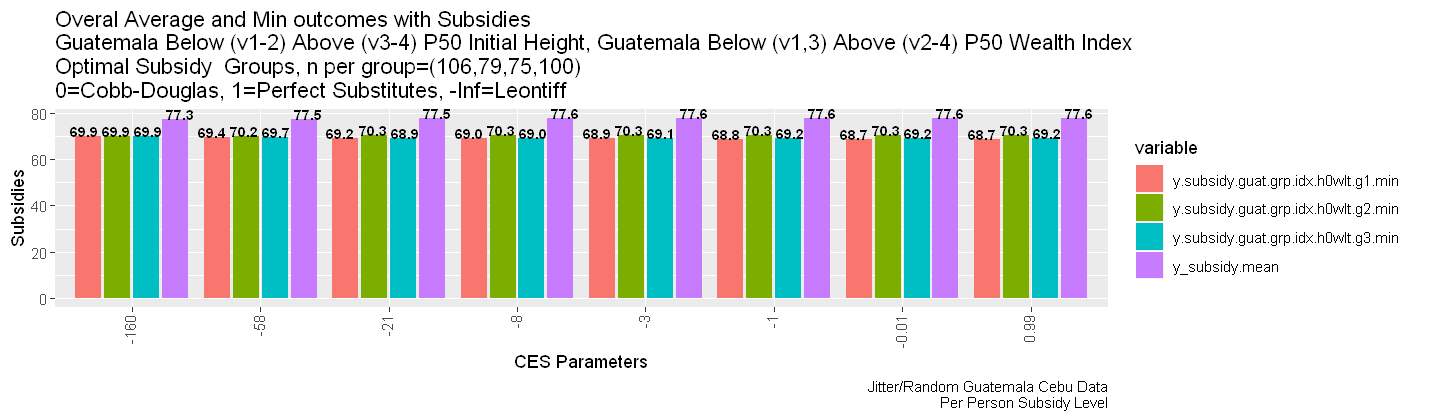

In [212]:
# test h0wlt
df.ces.opti.h0wlt <- bind_rows(lapply(vec.param.ces, optim_wrapper, 
                                list.subsidy.y.params.other = list.subsidy.y.params.other.default.h0wlt,
                                sca.subsidy.frac.init = (numeric((sca.subsidy.groups.h0wlt-1))+1), 
                                f.subsidy.y.str = 'f_subsidy_y_cd'))
t(df.ces.opti.h0wlt)

# Graph
options(repr.plot.width = 12, repr.plot.height = 3.5)
sca.subsidy.groups = list.subsidy.y.params.other.default.h0wlt$sca.subsidy.groups
vec.subsidy.grpsize =  list.subsidy.y.params.other.default.h0wlt$vec.subsidy.grpsize
# Two Graphs
# G1 
str.title <- paste0('Subsidy Per Person Fraction Normalized',
                    '\nGuatemala Below (v1-2) Above (v3-4) P50 Initial Height, ',
                    'Guatemala Below (v1,3) Above (v2-4) P50 Wealth Index')
str.captions <- 'Jitter/Random Guatemala Cebu Data\nRelative Subsidy Individuals Normalized'
graphf.ces.opti.subsidy(df.ces.opti=df.ces.opti.h0wlt %>% select(param.ces, matches('par.frac.norm.v')),
                        sca.subsidy.groups = sca.subsidy.groups, vec.subsidy.grpsize = vec.subsidy.grpsize, 
                        str.title=str.title, str.captions=str.captions, geom_text_format='%.1f')
str.title <- paste0('Subsidy Per Person Level',
                    '\nGuatemala Below (v1-2) Above (v3-4) P50 Initial Height, ',
                    'Guatemala Below (v1,3) Above (v2-4) P50 Wealth Index')
str.captions <- 'Jitter/Random Guatemala Cebu Data\nPer Person Subsidy Level'
graphf.ces.opti.subsidy(df.ces.opti=df.ces.opti.h0wlt %>% select(param.ces, matches('par.frac.lvl.v')),
                        sca.subsidy.groups = sca.subsidy.groups, vec.subsidy.grpsize = vec.subsidy.grpsize, 
                        str.title=str.title, str.captions=str.captions, geom_text_format='%.1f')
str.title <- paste0('Overal Average and Min outcomes with Subsidies',
                    '\nGuatemala Below (v1-2) Above (v3-4) P50 Initial Height, ',
                    'Guatemala Below (v1,3) Above (v2-4) P50 Wealth Index')
str.captions <- 'Jitter/Random Guatemala Cebu Data\nPer Person Subsidy Level'
graphf.ces.opti.subsidy(df.ces.opti=df.ces.opti.h0wlt %>% select(param.ces,
                                                                 y.subsidy.guat.grp.idx.h0wlt.g1.min,
                                                                 y.subsidy.guat.grp.idx.h0wlt.g2.min,
                                                                 y.subsidy.guat.grp.idx.h0wlt.g3.min, 
                                                                 y_subsidy.mean),
                        sca.subsidy.groups = sca.subsidy.groups, vec.subsidy.grpsize = vec.subsidy.grpsize, 
                        str.title=str.title, str.captions=str.captions, geom_text_format='%.1f')